### Load packages & data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import re
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

In [40]:
Flist = pd.read_csv("furniture_data_img.csv")
Flist.head()

,Label,Furniture_Type,Image_File
0,furniture set,Other,/furniture_images/1634011558853_Furniture Set ...
1,bed room set,Bed / bedroom item,/furniture_images/1634011559093_Bed Room Set f...
2,6by6 teak box bed with hybrids mattress,Bed / bedroom item,/furniture_images/1634011559259_6by6 Teak Box ...
3,new spring mattress,Bed / bedroom item,/furniture_images/1634011559590_New Spring Mat...
4,exclusive 6 by teak box bed with spring mattress,Bed / bedroom item,/furniture_images/1634011559751_Exclusive 6 by...


In [13]:
Flist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           9346 non-null   object
 1   Furniture_Type  9346 non-null   object
 2   Image_File      9346 non-null   object
dtypes: object(3)
memory usage: 219.2+ KB


- 데이터에는 가구의 유형을 크게 나눈 Furniture_Type 변수와 세부적인 분류로 나눈 Label 변수가 있다.

In [12]:
Flist['Furniture_Type'].value_counts()

Bed / bedroom item         3043
Table / chair              2419
Sofa / living room item    1813
Storage                    1326
Other                       270
TV / stereo                 244
Antique / art               209
Textiles / decoration        21
Lighting                      1
Name: Furniture_Type, dtype: int64

In [11]:
Flist['Label'].value_counts()

sofa set                                                             337
tv stand                                                             125
table                                                                 98
dressing table                                                        61
office chair                                                          48
                                                                    ... 
depo teak heavy modern dining table and 6 chairs code 8184             1
spring bed (single)                                                    1
teak large melon sofa set with glass stool - tlms055                   1
teak heavy modern indian box sofa set with stone table code 9014       1
tv cupbord                                                             1
Name: Label, Length: 6793, dtype: int64

value_counts() 결과에 따르면 Furniture_Type은 9개의 범주로 이루어져 있고 Label 변수는 무려 6793개의 범주로 이루어져 있다.    
Label 변수를 타겟변수로 사용하기에는 범주가 매우 많다고 판단하여 Furiture_Type 변수를 타겟변수로 사용한다.    
Furniture_Type의 범주 중 Lighting의 경우 데이터가 1개밖에 없으므로 train, valid, test set으로 나눌 수 없다. 따라서 해당 데이터는 삭제한다.

In [17]:
Flist[Flist['Furniture_Type']=='Lighting']

,Label,Furniture_Type,Image_File
265,lamp stand,Lighting,/furniture_images/1634012522134_Lamp Stand for...


In [41]:
Flist = Flist.drop(265, axis=0).reset_index(drop=True)

- 이후 데이터를 로드할 때 편의를 위해 현재 Image_File 내 값의 앞부분에 붙어있는 /furniture_images/ 를 제외한다.

In [42]:
Flist['Image_File']=[file.split("/")[2] for file in Flist['Image_File']]

In [71]:
Flist.head()

,Label,Furniture_Type,Image_File
0,furniture set,Other,1634011558853_Furniture Set for sale.jpg
1,bed room set,Bed / bedroom item,1634011559093_Bed Room Set for sale.jpg
2,6by6 teak box bed with hybrids mattress,Bed / bedroom item,1634011559259_6by6 Teak Box Bed with Hybrids M...
3,new spring mattress,Bed / bedroom item,1634011559590_New Spring Mattress for sale.jpg
4,exclusive 6 by teak box bed with spring mattress,Bed / bedroom item,1634011559751_Exclusive 6 by Teak Box Bed with...


- Image_File의 일부 값 중 특수문자로 불러와지는 값들이 있다.

In [77]:
Flist[1:30]

,Label,Furniture_Type,Image_File
1,bed room set,Bed / bedroom item,1634011559093_Bed Room Set for sale.jpg
2,6by6 teak box bed with hybrids mattress,Bed / bedroom item,1634011559259_6by6 Teak Box Bed with Hybrids M...
3,new spring mattress,Bed / bedroom item,1634011559590_New Spring Mattress for sale.jpg
4,exclusive 6 by teak box bed with spring mattress,Bed / bedroom item,1634011559751_Exclusive 6 by Teak Box Bed with...
5,tv stand,TV / stereo,1634011559907_Tv Stand for sale.jpg
6,exclusive 6 by 5 teak box bed with spring matt...,Bed / bedroom item,1634011560082_Exclusive 6 by 5 Teak Box Bed wi...
7,new phoenix 6 pc drawer set,Storage,1634011560266_New Phoenix 6 Pc Drawer Set for ...
8,exclusive 6 by teak box bed,Bed / bedroom item,1634011560797_Exclusive 6 by Teak Box Bed for ...
9,tv stand,TV / stereo,1634011561104_Tv Stand for sale.jpg
10,coffee table,Table / chair,1634011561290_Coffee table for sale.jpg


출력한 앞부분의 데이터들 중 27번째 값에서 영어가 아닌 다른 문자가 확인된다.      
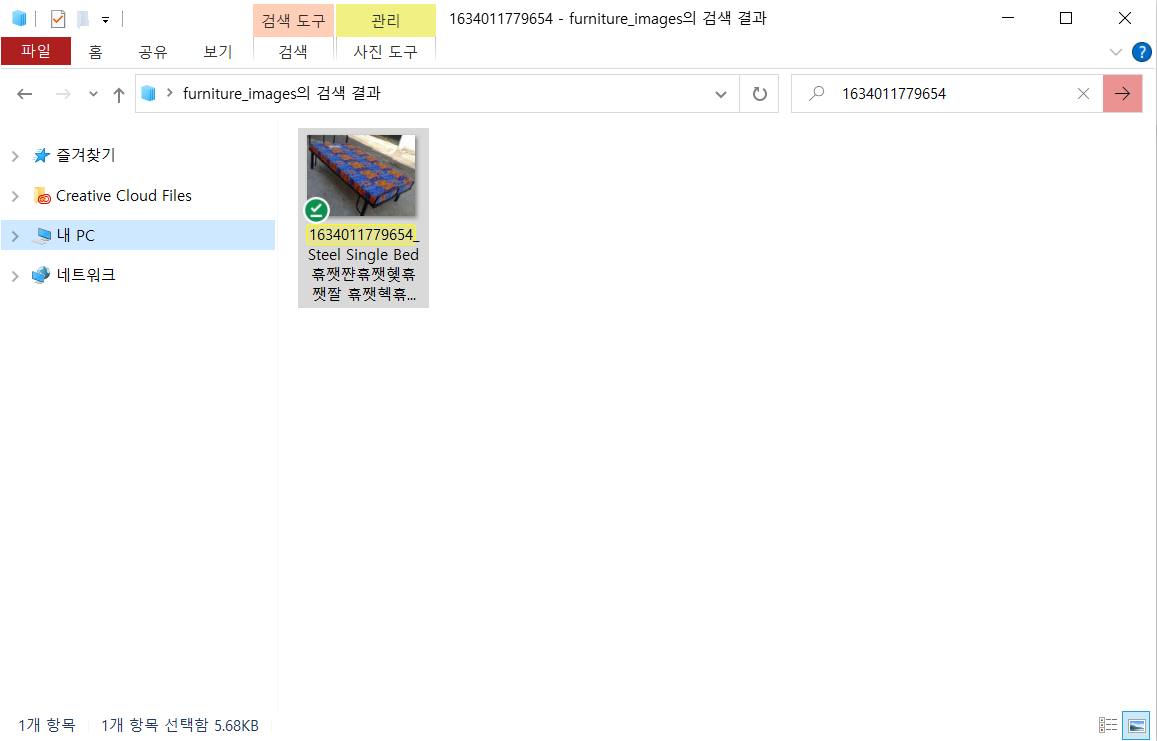
실제로 파일명을 검색해서 찾아보면 해당 데이터는 다음과 같이 알 수 없는 말로 표현된 제목을 가진 파일이다. 이 경우 데이터를 로드할 때 인식이 불가능하므로 영어 대소문자와 숫자, 언더바를 제외한 문자가 포함된 경우는 분석에서 제외한다.    
우선 이에 해당하는 파일이 몇개인지 확인해본다.

In [43]:
count = 0
for i in range(len(Flist['Image_File'])):
    if re.search('[^a-zA-Z0-9_. ]', Flist['Image_File'][i]):
        count += 1
count

366

In [44]:
dropidx = []
for i in range(len(Flist['Image_File'])):
    if re.search('[^a-zA-Z0-9_. ]', Flist['Image_File'][i]):
        dropidx.append(i)
Flist = Flist.drop(dropidx, axis=0).reset_index(drop=True)

- 1개의 이미지를 불러와서 shape을 확인하고 이미지를 시각화해본다.

In [123]:
path='./furniture_images/1634011558853_Furniture Set for sale.jpg'

image_pil = Image.open(path)
image = np.array(image_pil)
image.shape

(120, 160, 3)

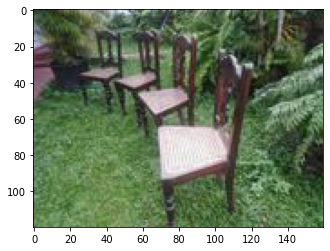

In [125]:
plt.imshow(image);

사진은 (120, 160, 3)의 크기를 갖는다.

- train, validation, test set으로 나눠 각 label별로 해당 사진들이 담긴 폴더를 만든다.

In [4]:
# 현재 이미지 파일이 있는 경로 지정
original_dataset_dir = './furniture_images'

# label별 폴더를 만들 경로 지정
base_dir = './Furniture'

# train/validation/test 폴더 생성
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
valid_dir = os.path.join(base_dir, 'valid')
#os.mkdir(valid_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

In [20]:
# label별 train, valid, test set 경로 지정
train_bb_dir = os.path.join(train_dir, 'Bed_bedroom item') ; os.mkdir(train_bb_dir)
train_tc_dir = os.path.join(train_dir, 'Table_chair') ; os.mkdir(train_tc_dir)
train_sl_dir = os.path.join(train_dir, 'sofa_living room item') ; os.mkdir(train_sl_dir)
train_st_dir = os.path.join(train_dir, 'Storage') ; os.mkdir(train_st_dir)
train_ot_dir = os.path.join(train_dir, 'Other') ; os.mkdir(train_ot_dir)
train_ts_dir = os.path.join(train_dir, 'TV_stereo') ; os.mkdir(train_ts_dir)
train_aa_dir = os.path.join(train_dir, 'Antique_art') ; os.mkdir(train_aa_dir)
train_td_dir = os.path.join(train_dir, 'Textiles_decoration') ; os.mkdir(train_td_dir)

valid_bb_dir = os.path.join(valid_dir, 'Bed_bedroom item') ; os.mkdir(valid_bb_dir)
valid_tc_dir = os.path.join(valid_dir, 'Table_chair') ; os.mkdir(valid_tc_dir)
valid_sl_dir = os.path.join(valid_dir, 'sofa_living room item') ; os.mkdir(valid_sl_dir)
valid_st_dir = os.path.join(valid_dir, 'Storage') ; os.mkdir(valid_st_dir)
valid_ot_dir = os.path.join(valid_dir, 'Other') ; os.mkdir(valid_ot_dir)
valid_ts_dir = os.path.join(valid_dir, 'TV_stereo') ; os.mkdir(valid_ts_dir)
valid_aa_dir = os.path.join(valid_dir, 'Antique_art') ; os.mkdir(valid_aa_dir)
valid_td_dir = os.path.join(valid_dir, 'Textiles_decoration') ; os.mkdir(valid_td_dir)

test_bb_dir = os.path.join(test_dir, 'Bed_bedroom item') ; os.mkdir(test_bb_dir)
test_tc_dir = os.path.join(test_dir, 'Table_chair') ; os.mkdir(test_tc_dir)
test_sl_dir = os.path.join(test_dir, 'sofa_living room item') ; os.mkdir(test_sl_dir)
test_st_dir = os.path.join(test_dir, 'Storage') ; os.mkdir(test_st_dir)
test_ot_dir = os.path.join(test_dir, 'Other') ; os.mkdir(test_ot_dir)
test_ts_dir = os.path.join(test_dir, 'TV_stereo') ; os.mkdir(test_ts_dir)
test_aa_dir = os.path.join(test_dir, 'Antique_art') ; os.mkdir(test_aa_dir)
test_td_dir = os.path.join(test_dir, 'Textiles_decoration') ; os.mkdir(test_td_dir)

In [116]:
# label별 파일명 지정, train/valid/test set 분리를 위해 0.6/0.2 비율 확인
file_bb=Flist[Flist['Furniture_Type']=='Bed / bedroom item']['Image_File']
print("Bed / bedroom item", len(file_bb)*0.6, len(file_bb)*0.2)
file_tc=Flist[Flist['Furniture_Type']=='Table / chair']['Image_File']
print("Table / chair", len(file_tc)*0.6, len(file_tc)*0.2)
file_sl=Flist[Flist['Furniture_Type']=='Sofa / living room item']['Image_File']
print("Sofa / living room item", len(file_sl)*0.6, len(file_sl)*0.2)
file_st=Flist[Flist['Furniture_Type']=='Storage']['Image_File']
print("Storage", len(file_st)*0.6, len(file_st)*0.2)
file_ot=Flist[Flist['Furniture_Type']=='Other']['Image_File']
print("Other", len(file_ot)*0.6, len(file_ot)*0.2)
file_ts=Flist[Flist['Furniture_Type']=='TV / stereo']['Image_File']
print("TV / stereo", len(file_ts)*0.6, len(file_ts)*0.2)
file_aa=Flist[Flist['Furniture_Type']=='Antique / art']['Image_File']
print("Antique / art", len(file_aa)*0.6, len(file_aa)*0.2)
file_td=Flist[Flist['Furniture_Type']=='Textiles / decoration']['Image_File']
print("Textiles / decoration", len(file_td)*0.6, len(file_td)*0.2)

Bed / bedroom item 1703.3999999999999 567.8000000000001
Table / chair 1422.6 474.20000000000005
Sofa / living room item 1070.3999999999999 356.8
Storage 778.8 259.6
Other 143.4 47.800000000000004
TV / stereo 144.6 48.2
Antique / art 112.8 37.6
Textiles / decoration 11.4 3.8000000000000003


train:valid:test = 6:2:2 의 비율로 나눈다.

In [118]:
# train file path
for fname in file_bb[:1703].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_bb_dir,fname)
    shutil.copyfile(src, dst)

for fname in file_tc[:1423].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_tc_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_sl[:1070].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_sl_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_st[:779].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_st_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ot[:143].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_ot_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ts[:145].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_ts_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_aa[:113].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_aa_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_td[:11].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_td_dir, fname)
    shutil.copyfile(src, dst)

In [119]:
# valid file path
for fname in file_bb[1703:(1703+568)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_bb_dir,fname)
    shutil.copyfile(src, dst)

for fname in file_tc[1423:(1423+474)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_tc_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_sl[1070:(1070+357)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_sl_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_st[779:(779+260)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_st_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ot[143:(143+48)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_ot_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ts[145:(145+48)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_ts_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_aa[113:(113+38)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_aa_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_td[11:(11+4)].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_td_dir, fname)
    shutil.copyfile(src, dst)

In [120]:
# test file path
for fname in file_bb[(1703+568):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_bb_dir,fname)
    shutil.copyfile(src, dst)

for fname in file_tc[(1423+474):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_tc_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_sl[(1070+357):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_sl_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_st[(779+260):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_st_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ot[(143+48):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_ot_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_ts[(145+48):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_ts_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_aa[(113+38):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_aa_dir, fname)
    shutil.copyfile(src, dst)
    
for fname in file_td[(11+4):].reset_index(drop=True):
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_td_dir, fname)
    shutil.copyfile(src, dst)

#### 모델링 1) 소형 합성망

In [8]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3))) 
model1.add(layers.MaxPooling2D((2, 2))) 
model1.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model1.add(layers.MaxPooling2D((2, 2))) 
model1.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model1.add(layers.MaxPooling2D((2, 2))) 
model1.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model1.add(layers.MaxPooling2D((2, 2))) 
model1.add(layers.Flatten()) 
model1.add(layers.Dense(64, activation='relu')) 
model1.add(layers.Dense(8, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 16, 128)       1

In [11]:
# compile
model1.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01), 
              metrics=[keras.metrics.categorical_accuracy])

In [2]:
# data generate
train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

In [5]:
# train set
train_generator = train_datagen.flow_from_directory( 
    train_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')

Found 5387 images belonging to 8 classes.


In [6]:
# validation set
validation_generator = test_datagen.flow_from_directory( 
    valid_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')

Found 1797 images belonging to 8 classes.


In [7]:
for data_batch, labels_batch in train_generator: 
    print(data_batch.shape) 
    print(labels_batch.shape) 
    break

(50, 120, 160, 3)
(50, 8)


In [12]:
# Model fitting
history = model1.fit(train_generator, epochs=30, steps_per_epoch=100,
                   validation_data=validation_generator)

Epoch 1/30
100/100 [==============================] - 78s 773ms/step - loss: 1.6755 - categorical_accuracy: 0.3158 - val_loss: 1.5997 - val_categorical_accuracy: 0.3194
Epoch 2/30
100/100 [==============================] - 70s 702ms/step - loss: 1.5908 - categorical_accuracy: 0.3218 - val_loss: 1.5868 - val_categorical_accuracy: 0.3389
Epoch 3/30
100/100 [==============================] - 69s 689ms/step - loss: 1.5873 - categorical_accuracy: 0.3411 - val_loss: 1.5983 - val_categorical_accuracy: 0.3356
Epoch 4/30
100/100 [==============================] - 68s 679ms/step - loss: 1.5715 - categorical_accuracy: 0.3471 - val_loss: 1.5722 - val_categorical_accuracy: 0.3550
Epoch 5/30
100/100 [==============================] - 69s 687ms/step - loss: 1.5613 - categorical_accuracy: 0.3517 - val_loss: 1.5795 - val_categorical_accuracy: 0.3328
Epoch 6/30
100/100 [==============================] - 70s 704ms/step - loss: 1.5546 - categorical_accuracy: 0.3585 - val_loss: 1.5583 - val_categorical_acc

In [13]:
# save model
model1.save('model1_smallcnn.h5')

In [15]:
history.history

{'loss': [1.6755212545394897,
  1.5908408164978027,
  1.5872976779937744,
  1.571475625038147,
  1.5613429546356201,
  1.5545910596847534,
  1.543774127960205,
  1.5367496013641357,
  1.5222077369689941,
  1.5041110515594482,
  1.4885520935058594,
  1.4714223146438599,
  1.453202724456787,
  1.4325839281082153,
  1.4120248556137085,
  1.3981925249099731,
  1.358934998512268,
  1.3407928943634033,
  1.313925862312317,
  1.2959141731262207,
  1.2743417024612427,
  1.2366609573364258,
  1.1987990140914917,
  1.177314043045044,
  1.1408954858779907,
  1.1276962757110596,
  1.085909128189087,
  1.0694724321365356,
  1.031196117401123,
  1.0068936347961426],
 'categorical_accuracy': [0.3158211410045624,
  0.32179999351501465,
  0.34108683466911316,
  0.34710246324539185,
  0.35171446204185486,
  0.358532190322876,
  0.3627431392669678,
  0.3737718164920807,
  0.38339683413505554,
  0.39201924204826355,
  0.40779998898506165,
  0.4166833758354187,
  0.42650893330574036,
  0.4383396804332733,


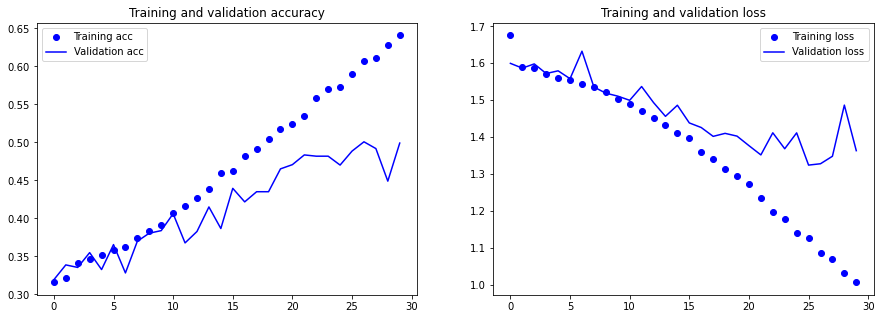

In [20]:
# accuracy & loss plot
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(acc)) 

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 모델링 2) Augmetation data를 이용한 합성망 모델링

과적합 방지를 위해 dropout을 추가한 모델 생성

In [21]:
model2 = models.Sequential() 
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3))) 
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Flatten()) 
model2.add(layers.Dropout(0.5)) 
model2.add(layers.Dense(512, activation='relu')) 
model2.add(layers.Dense(8, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 38, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 18, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 16, 128)      

In [22]:
#compile
model2.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01), 
              metrics=[keras.metrics.categorical_accuracy])

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
# data generator
train_datagen = ImageDataGenerator( 
    rescale=1./255, rotation_range=40, 
    width_shift_range=0.2, height_shift_range=0.2, 
    shear_range=0.2, zoom_range=0.2, 
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory( train_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory( valid_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')

Found 5387 images belonging to 8 classes.
Found 1797 images belonging to 8 classes.


In [29]:
# Model fitting
history = model2.fit_generator(train_generator, epochs=50, steps_per_epoch=100,
                   validation_data=validation_generator)

Epoch 1/50
100/100 [==============================] - 73s 730ms/step - loss: 1.6040 - categorical_accuracy: 0.3090 - val_loss: 1.6008 - val_categorical_accuracy: 0.3177
Epoch 2/50
100/100 [==============================] - 72s 721ms/step - loss: 1.6007 - categorical_accuracy: 0.3086 - val_loss: 1.5938 - val_categorical_accuracy: 0.3206
Epoch 3/50
100/100 [==============================] - 75s 744ms/step - loss: 1.5976 - categorical_accuracy: 0.3078 - val_loss: 1.5914 - val_categorical_accuracy: 0.3189
Epoch 4/50
100/100 [==============================] - 75s 750ms/step - loss: 1.5951 - categorical_accuracy: 0.3124 - val_loss: 1.5917 - val_categorical_accuracy: 0.3480
Epoch 5/50
100/100 [==============================] - 76s 754ms/step - loss: 1.5974 - categorical_accuracy: 0.3214 - val_loss: 1.5923 - val_categorical_accuracy: 0.3309
Epoch 6/50
100/100 [==============================] - 77s 769ms/step - loss: 1.5949 - categorical_accuracy: 0.3114 - val_loss: 1.5841 - val_categorical_acc

100/100 [==============================] - 68s 678ms/step - loss: 1.4205 - categorical_accuracy: 0.4424 - val_loss: 1.4073 - val_categorical_accuracy: 0.4583
Epoch 50/50
100/100 [==============================] - 67s 668ms/step - loss: 1.4124 - categorical_accuracy: 0.4405 - val_loss: 1.4007 - val_categorical_accuracy: 0.4497


In [30]:
# save model
model2.save('model2_smallcnn_dataaug.h5')

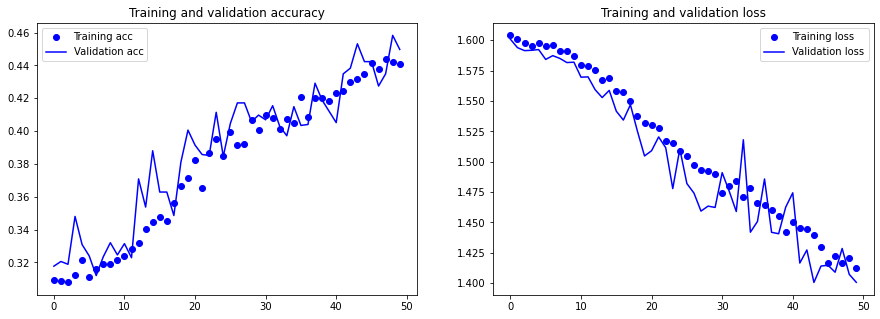

In [31]:
# accuracy & loss plot
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(acc)) 

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 모델링 3) 사전 훈련 합성망 - VGG16 합성곱 기반 모형: vgg16 출력값을 분류기의 입력값으로 사용

In [33]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(120, 160, 3))
conv_base.summary()

58900480/58889256 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 80, 128)       147584    
______________________________________________________________

In [50]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 50

def extract_features(directory, sample_count): 
    features = np.zeros(shape=(sample_count, 3, 5, 512)) 
    labels = np.zeros(shape=(sample_count)) 
    generator = datagen.flow_from_directory( 
        directory, target_size=(120, 160), batch_size=batch_size, class_mode='sparse') 
    i = 0 
    for inputs_batch, labels_batch in generator: 
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
        i += 1 
        if i * batch_size >= sample_count: 
            break 
    return features, labels

train_features, train_labels = extract_features(train_dir, 5387)
validation_features, validation_labels = extract_features(valid_dir, 1797)
test_features, test_labels = extract_features(test_dir, 1795)

Found 5387 images belonging to 8 classes.
Found 1797 images belonging to 8 classes.
Found 1795 images belonging to 8 classes.


In [51]:
train_features = np.reshape(train_features, (5387, 3 * 5 * 512)) 
validation_features = np.reshape(validation_features, (1797, 3 * 5 * 512)) 
test_features = np.reshape(test_features, (1795, 3 * 5 * 512))

In [53]:
model3 = models.Sequential() 
model3.add(layers.Dense(256, activation='relu', input_dim=3 * 5 * 512)) 
model3.add(layers.Dropout(0.5)) 
model3.add(layers.Dense(8, activation='softmax')) 

In [84]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               1966336   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 1,968,392
Trainable params: 1,968,392
Non-trainable params: 0
_________________________________________________________________


In [56]:
#compile
model3.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01), 
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [57]:
history = model3.fit(train_features, train_labels, epochs=50, batch_size=50, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/50
108/108 [==============================] - 1s 9ms/step - loss: 1.4823 - sparse_categorical_accuracy: 0.4359 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.5420
Epoch 2/50
108/108 [==============================] - 1s 8ms/step - loss: 1.2305 - sparse_categorical_accuracy: 0.5498 - val_loss: 1.1409 - val_sparse_categorical_accuracy: 0.5838
Epoch 3/50
108/108 [==============================] - 1s 8ms/step - loss: 1.1404 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.0824 - val_sparse_categorical_accuracy: 0.6194
Epoch 4/50
108/108 [==============================] - 1s 8ms/step - loss: 1.0733 - sparse_categorical_accuracy: 0.6308 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.6082
Epoch 5/50
108/108 [==============================] - 1s 8ms/step - loss: 1.0317 - sparse_categorical_accuracy: 0.6406 - val_loss: 1.0341 - val_sparse_categorical_accuracy: 0.6255
Epoch 6/50
108/108 [==============================] - 1s 8ms/step - loss: 1.0094 - sparse_categorica

108/108 [==============================] - 1s 8ms/step - loss: 0.4796 - sparse_categorical_accuracy: 0.8272 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.7067
Epoch 47/50
108/108 [==============================] - 1s 7ms/step - loss: 0.4792 - sparse_categorical_accuracy: 0.8279 - val_loss: 0.9269 - val_sparse_categorical_accuracy: 0.6845
Epoch 48/50
108/108 [==============================] - 1s 7ms/step - loss: 0.4707 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.9035 - val_sparse_categorical_accuracy: 0.7101
Epoch 49/50
108/108 [==============================] - 1s 7ms/step - loss: 0.4554 - sparse_categorical_accuracy: 0.8411 - val_loss: 0.8906 - val_sparse_categorical_accuracy: 0.7056
Epoch 50/50
108/108 [==============================] - 1s 7ms/step - loss: 0.4558 - sparse_categorical_accuracy: 0.8418 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.6917


In [58]:
# save model
model3.save('model3_vgg16_1.h5')

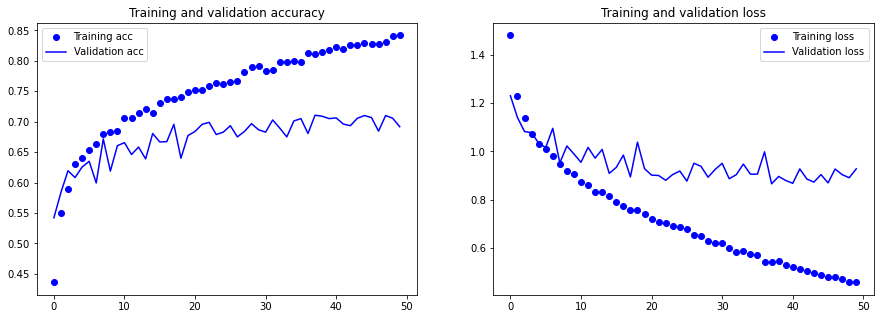

In [61]:
# accuracy & loss plot
acc = history.history['sparse_categorical_accuracy'] 
val_acc = history.history['val_sparse_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(acc)) 

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 모델링 4) 사전 훈련 합성망 - VGG16 합성곱 기반 모형: vgg16 layer부터 끝까지 모든 layer를 실행

In [62]:
model4 = models.Sequential() 
model4.add(conv_base) 
model4.add(layers.Flatten()) 
model4.add(layers.Dense(256, activation='relu')) 
model4.add(layers.Dense(8, activation='softmax'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               1966336   
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 16,683,080
Trainable params: 16,683,080
Non-trainable params: 0
_________________________________________________________________


In [63]:
# data augmentation
train_datagen = ImageDataGenerator( rescale=1./255, 
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory( train_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory( valid_dir, target_size=(120, 160), batch_size=50, class_mode='categorical')

Found 5387 images belonging to 8 classes.
Found 1797 images belonging to 8 classes.


In [64]:
#compile
model4.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=0.01), 
              metrics=[keras.metrics.categorical_accuracy])

In [70]:
# Model fitting
history = model4.fit_generator(train_generator,
                               epochs=30, steps_per_epoch=100,
                   validation_data=validation_generator, validation_steps=35)

Epoch 1/30
100/100 [==============================] - 849s 8s/step - loss: 1.4250 - categorical_accuracy: 0.4341 - val_loss: 1.1058 - val_categorical_accuracy: 0.5989
Epoch 2/30
100/100 [==============================] - 968s 10s/step - loss: 1.0868 - categorical_accuracy: 0.6124 - val_loss: 0.9220 - val_categorical_accuracy: 0.6909
Epoch 3/30
100/100 [==============================] - 979s 10s/step - loss: 0.9257 - categorical_accuracy: 0.6788 - val_loss: 0.9167 - val_categorical_accuracy: 0.6817
Epoch 4/30
100/100 [==============================] - 986s 10s/step - loss: 0.8372 - categorical_accuracy: 0.7143 - val_loss: 0.8302 - val_categorical_accuracy: 0.7120
Epoch 5/30
100/100 [==============================] - 987s 10s/step - loss: 0.7648 - categorical_accuracy: 0.7397 - val_loss: 0.8564 - val_categorical_accuracy: 0.7263
Epoch 6/30
100/100 [==============================] - 982s 10s/step - loss: 0.7074 - categorical_accuracy: 0.7526 - val_loss: 1.0296 - val_categorical_accuracy: 

In [72]:
# save model
model4.save('model4_vgg16_2.h5')

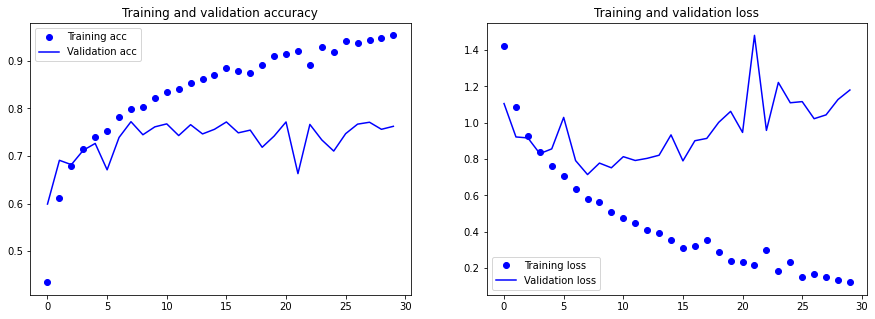

In [73]:
# accuracy & loss plot
acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(len(acc)) 

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [103]:
test_generator = test_datagen.flow_from_directory( 
    test_dir, target_size=(120, 160), 
    batch_size=50, class_mode='categorical')

Found 1795 images belonging to 8 classes.


In [96]:
# test accuracy - model1
test_loss1, test_acc1 = model1.evaluate_generator(test_generator, steps=10)
print("loss:",test_loss1) 
print("accuracy:",test_acc1)

loss: 1.4029135704040527
accuracy: 0.47600001096725464


In [97]:
# test accuracy - model2
test_loss2, test_acc2 = model2.evaluate_generator(test_generator, steps=10)
print("loss:",test_loss2) 
print("accuracy:",test_acc2)

loss: 1.4641484022140503
accuracy: 0.39399999380111694


In [101]:
# test accuracy - model3
test_loss3, test_acc3 = model3.evaluate(test_features, test_labels)
print("loss:",test_loss3) 
print("accuracy:",test_acc3)

57/57 [==============================] - 0s 3ms/step - loss: 0.9947 - sparse_categorical_accuracy: 0.6635
loss: 0.9946524500846863
accuracy: 0.663509726524353


In [104]:
# test accuracy - model
test_loss4, test_acc4 = model4.evaluate_generator(test_generator, steps=10)
print("loss:",test_loss4) 
print("accuracy:",test_acc4)

loss: 1.494651198387146
accuracy: 0.7400000095367432
